We will be using the autotime extension to compute the execution time of each cell.
- `pip install ipython-autotime`
- `%load_ext autotime`

In [51]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 142 ms (started: 2022-05-19 18:13:53 +02:00)


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from mlflow.tracking import MlflowClient

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

np.random.seed(42)

plt.rcParams['figure.figsize'] = [10, 7]
pd.set_option("max_columns", None)

time: 68.4 ms (started: 2022-05-19 18:13:56 +02:00)


# Data setup

- Download the data from: https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant

## Preprocess the excel file data and merge all the data in a single csv fille

- Install xlrd with specific version that supports this format => `pip install xlrd==1.2.0`

In [53]:
#filepath = '../../data/power-plant/Folds5x2_pp.xlsx'
#df = pd.concat(pd.read_excel(filepath, sheet_name=None), ignore_index=True)
#df.head()

time: 284 µs (started: 2022-05-19 18:14:02 +02:00)


In [54]:
#df.to_csv("../../../data/power_plant/power_plants.csv", index=False)

time: 269 µs (started: 2022-05-19 18:14:02 +02:00)


## Load the csv file and add a device_id column to simulate having multiple IoT devices

In [55]:
df = pd.read_csv("../../../data/power_plant/power_plants.csv")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


time: 578 ms (started: 2022-05-19 18:14:03 +02:00)


- We want to simulate the fact of using multiple models in production at the same time (one model per IoT device). To do that, we can either split our data to 4 dataframes (1 dataframe per IoT device) or we can create a new column `device_id` where we specify the IoT device the record belongs to. We will go with the latter approach by assigning a random number between 1 and 4.

In [56]:
import numpy as np

df["device_id"] = np.random.randint(1, 5, size=len(df))
df.head()

,AT,V,AP,RH,PE,device_id
0,14.96,41.76,1024.07,73.17,463.26,3
1,25.18,62.96,1020.04,59.08,444.37,4
2,5.11,39.40,1012.16,92.14,488.56,1
3,20.86,57.32,1010.24,76.64,446.48,3
4,10.82,37.50,1009.23,96.62,473.90,3


time: 35.6 ms (started: 2022-05-19 18:14:36 +02:00)


In [57]:
df.device_id.value_counts()

1    12081
4    11995
3    11897
2    11867
Name: device_id, dtype: int64

time: 22.5 ms (started: 2022-05-19 18:14:44 +02:00)


# Model training

## Train model function

Create a function that trains a model for a single device. It should take the device dataframe as input an do the following steps:
- Split the data into training and test set
- Trains a `RandomForestRegressor`
- Evaluates it with `MAE`, `MSE` and `RMSE`
- Returns a dictionary with the following informations
    - `device_id`
    - `test_mae`
    - `test_mse`
    - `test_rmse`

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_model_for_an_iot_device(device_df: pd.DataFrame) -> dict:
    """Trains a model for a single device"""
    device_id = device_df.iloc[0].device_id
    
    # Split data
    X = device_df[["AT", "V", "AP", "RH"]]
    y = device_df["PE"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit model
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    ret_dict = {
        "device_id": device_id,
        "test_mae": test_mae,
        "test_mse": test_mse,
        "test_rmse": test_rmse
    }
    return ret_dict

time: 1.04 ms (started: 2022-05-19 18:15:42 +02:00)


## Train a model for all the devices

Now that we can train a model for a given IoT device, let's orchestrate the training for all device models given the full dataset (sensor measures from all the IoT devices).

Create a function `train_models_for_all_iot_devices` that will take the full data and call the `train_model_for_an_iot_device` function with the corresponding device data. This function shouldd return a dataframe where each row corresponds to each device model training metadata (`device_id`, `fitted_model`, `test_mae`, `test_mse`, `test_rmse`).

In [61]:
def train_models_for_all_iot_devices(data: pd.DataFrame) -> pd.DataFrame:
    ret_dict_list = []
    for device_id in data.device_id.unique():
        iot_device_df = data[data.device_id == device_id]
        ret_dict_list.append(train_model_for_an_iot_device(iot_device_df))
    return ret_dict_list

time: 415 µs (started: 2022-05-19 18:16:14 +02:00)


In [62]:
train_models_for_all_iot_devices(df)

2022/05/19 18:16:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b117f8bc50d644bf80cde619c0d2b975', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/19 18:16:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a90ba7bbd5ab432a8567b35aed25f12a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/19 18:16:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5852c633e9c240e18e404b930dc003f2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/05/19 18:16:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c0273eedee1041a2b3723062da87d66b', which will track hyperparameters, performance metrics, model artifacts, and lineage i

[{'device_id': 3.0,
  'test_mae': 1.3441227310924548,
  'test_mse': 4.980053701609265,
  'test_rmse': 2.2316033925429637},
 {'device_id': 4.0,
  'test_mae': 1.3288173822425904,
  'test_mse': 4.490531473192989,
  'test_rmse': 2.1190874151844206},
 {'device_id': 1.0,
  'test_mae': 1.398851799751759,
  'test_mse': 4.837214989433202,
  'test_rmse': 2.1993669519734995},
 {'device_id': 2.0,
  'test_mae': 1.4562355096882917,
  'test_mse': 5.368358264941064,
  'test_rmse': 2.3169717876877707}]

time: 33.1 s (started: 2022-05-19 18:16:15 +02:00)


## Mlflow integration

`mlflow server --backend-store-uri sqlite:////tmp/mlruns.db --default-artifact-root /tmp/mlruns`

In [68]:
mlflow.set_tracking_uri('http://127.0.0.1:5000')

time: 412 µs (started: 2022-05-19 18:17:59 +02:00)


In [69]:
experiment_name = "Iot device model training"

mlflow.set_experiment(experiment_name)

experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
experiment_id

INFO: 'Iot device model training' does not exist. Creating a new experiment


'1'

time: 604 ms (started: 2022-05-19 18:17:59 +02:00)


In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_model_for_an_iot_device(device_df: pd.DataFrame) -> dict:
    """Trains a model for a single device"""
    device_id = device_df.iloc[0].device_id
    
    with mlflow.start_run():
        mlflow.sklearn.autolog()

        # Split data
        X = device_df[["AT", "V", "AP", "RH"]]
        y = device_df["PE"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        mlflow.log_params(
            {"nb_sample": len(X), "nb_training_samples": len(X_train), "nb_testing_samples": len(X_test)})

        # Fit model
        model = RandomForestRegressor()
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)

        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metrics({"test_mae": test_mae, "test_mse": test_mse, "test_rmse": test_rmse})

        ret_dict = {
            "device_id": device_id,
            "test_mae": test_mae,
            "test_mse": test_mse,
            "test_rmse": test_rmse
        }
    return ret_dict

time: 1.05 ms (started: 2022-05-19 18:18:43 +02:00)


In [71]:
def train_models_for_all_iot_devices(data: pd.DataFrame) -> pd.DataFrame:
    ret_dict_list = []
    for device_id in data.device_id.unique():
        iot_device_df = data[data.device_id == device_id]
        ret_dict_list.append(train_model_for_an_iot_device(iot_device_df))
    return ret_dict_list

time: 504 µs (started: 2022-05-19 18:18:44 +02:00)


In [72]:
train_models_for_all_iot_devices(df)

2022/05/19 18:18:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:18:56 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:19:03 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:19:11 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


[{'device_id': 3.0,
  'test_mae': 1.3384144117647068,
  'test_mse': 4.881391694121833,
  'test_rmse': 2.2093871761467776},
 {'device_id': 4.0,
  'test_mae': 1.3198726552730269,
  'test_mse': 4.415959547507313,
  'test_rmse': 2.101418460827665},
 {'device_id': 1.0,
  'test_mae': 1.4102796441870091,
  'test_mse': 4.847133325961946,
  'test_rmse': 2.2016206135394776},
 {'device_id': 2.0,
  'test_mae': 1.453237615838246,
  'test_mse': 5.294566555210641,
  'test_rmse': 2.300992515244376}]

time: 31.9 s (started: 2022-05-19 18:18:47 +02:00)


## Train a model each month

In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_model_for_an_iot_device(device_df: pd.DataFrame, month_name: str) -> dict:
    """Trains a model for a single device"""
    device_id = int(device_df.iloc[0].device_id)
    
    with mlflow.start_run(nested=True, run_name=f"device {device_id}"):
        mlflow.log_params({"device_id": device_id, "month": month_name})
        
        
        mlflow.sklearn.autolog()

        # Split data
        X = device_df[["AT", "V", "AP", "RH"]]
        y = device_df["PE"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        mlflow.log_params(
            {"nb_sample": len(X), "nb_training_samples": len(X_train), "nb_testing_samples": len(X_test)})

        # Fit model
        model = RandomForestRegressor()
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)

        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_squared_error(y_test, y_pred)
        test_rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metrics({"test_mae": test_mae, "test_mse": test_mse, "test_rmse": test_rmse})

        ret_dict = {
            "device_id": device_id,
            "test_mae": test_mae,
            "test_mse": test_mse,
            "test_rmse": test_rmse
        }
    return ret_dict

time: 2.13 ms (started: 2022-05-19 18:20:10 +02:00)


In [74]:
def train_models_for_all_iot_devices(data: pd.DataFrame, month_name: str) -> pd.DataFrame:
    with mlflow.start_run(run_name=month_name):
        ret_dict_list = []
        for device_id in data.device_id.unique():
            iot_device_df = data[data.device_id == device_id]
            ret_dict = train_model_for_an_iot_device(iot_device_df, month_name)
            ret_dict_list.append(ret_dict)
    return ret_dict_list

time: 641 µs (started: 2022-05-19 18:20:39 +02:00)


In [75]:
train_models_for_all_iot_devices(df, "june")

2022/05/19 18:20:42 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:20:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:20:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:21:06 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


[{'device_id': 3,
  'test_mae': 1.350027016806743,
  'test_mse': 5.006475746063059,
  'test_rmse': 2.2375155297926},
 {'device_id': 4,
  'test_mae': 1.3250245935806524,
  'test_mse': 4.489450530729456,
  'test_rmse': 2.1188323507841424},
 {'device_id': 1,
  'test_mae': 1.4050296235002135,
  'test_mse': 4.8156215658502335,
  'test_rmse': 2.194452452401335},
 {'device_id': 2,
  'test_mae': 1.4403748946925035,
  'test_mse': 5.22459497630161,
  'test_rmse': 2.28573729380732}]

time: 33 s (started: 2022-05-19 18:20:42 +02:00)


In [19]:
train_models_for_all_iot_devices(df, "july")

2022/05/19 16:12:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 16:12:24 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 16:12:33 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 16:12:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


[{'device_id': 3,
  'test_mae': 1.3356971848739658,
  'test_mse': 4.883434235894973,
  'test_rmse': 2.20984936950349},
 {'device_id': 4,
  'test_mae': 1.3278575239683221,
  'test_mse': 4.424305160425182,
  'test_rmse': 2.1034032329596677},
 {'device_id': 1,
  'test_mae': 1.4019553992552738,
  'test_mse': 4.790314462060397,
  'test_rmse': 2.188678702336274},
 {'device_id': 2,
  'test_mae': 1.4530315501263735,
  'test_mse': 5.35968878169759,
  'test_rmse': 2.31510016666614}]

time: 32.9 s (started: 2022-05-19 16:12:15 +02:00)


In [20]:
train_models_for_all_iot_devices(df, "august")

2022/05/19 16:12:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 16:12:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 16:13:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 16:13:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


[{'device_id': 3,
  'test_mae': 1.3464780252101014,
  'test_mse': 4.935150654634459,
  'test_rmse': 2.2215198974203356},
 {'device_id': 4,
  'test_mae': 1.3242604418507622,
  'test_mse': 4.500514834764469,
  'test_rmse': 2.1214416878067777},
 {'device_id': 1,
  'test_mae': 1.4105752999586216,
  'test_mse': 4.863400481021913,
  'test_rmse': 2.2053118784022168},
 {'device_id': 2,
  'test_mae': 1.4443000421230094,
  'test_mse': 5.292979398176116,
  'test_rmse': 2.3006476040837103}]

time: 32.2 s (started: 2022-05-19 16:12:48 +02:00)


# Simulate drift in the data

In [77]:
df_lower_distribution = df[df["PE"] < 450]

time: 88.5 ms (started: 2022-05-19 18:23:31 +02:00)


In [78]:
# Create 2 "months" worth of data from the same distribution
indexs = np.random.rand(len(df_lower_distribution))
indexs

array([0.80632897, 0.35475094, 0.81204524, ..., 0.26892028, 0.44214342,
       0.09560994])

time: 10.3 ms (started: 2022-05-19 18:23:38 +02:00)


In [81]:
mask = indexs < 0.5
df_march, df_april = df_lower_distribution[mask], df_lower_distribution[~mask]

time: 32.6 ms (started: 2022-05-19 18:24:08 +02:00)


<AxesSubplot:>

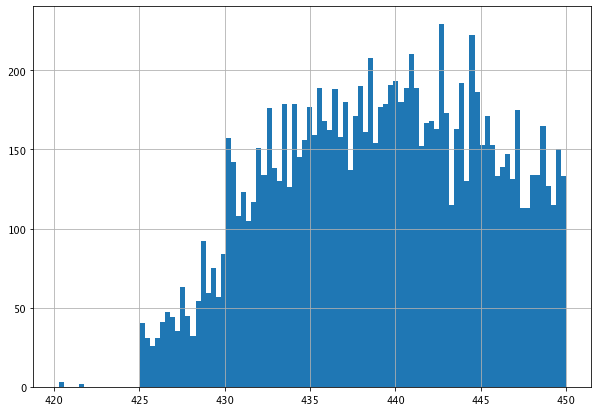

time: 608 ms (started: 2022-05-19 18:24:08 +02:00)


In [82]:
df_march["PE"].hist(bins=100)

<AxesSubplot:>

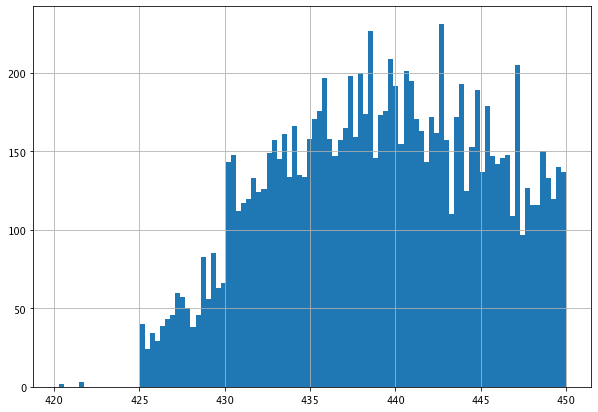

time: 643 ms (started: 2022-05-19 18:24:11 +02:00)


In [83]:
df_april["PE"].hist(bins=100)

<AxesSubplot:>

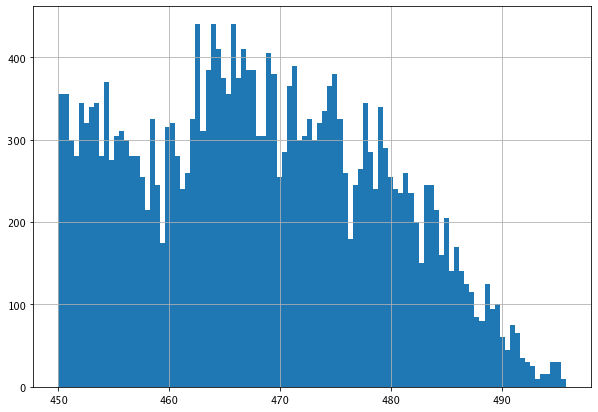

time: 680 ms (started: 2022-05-19 18:24:34 +02:00)


In [84]:
df_may = df[df["PE"] >= 450]
df_may["PE"].hist(bins=100)

# Train models for the different months

In [85]:
_ = train_models_for_all_iot_devices(df_march, "march")

2022/05/19 18:27:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:27:27 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:27:36 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:27:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


time: 33.7 s (started: 2022-05-19 18:27:18 +02:00)


## Register a model in the Model Registry

In [87]:
all_experiment_runs_df = mlflow.search_runs(experiment_id)
all_experiment_runs_df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_rmse,metrics.mean_squared_error-2_X_test,metrics.training_r2_score,metrics.test_mae,metrics.training_score,metrics.training_mse,metrics.training_mae,metrics.training_rmse,metrics.mean_absolute_error_X_test,metrics.mean_squared_error_X_test,metrics.test_mse,params.verbose,params.min_weight_fraction_leaf,params.oob_score,params.bootstrap,params.month,params.random_state,params.nb_testing_samples,params.min_samples_leaf,params.min_impurity_decrease,params.max_depth,params.device_id,params.n_jobs,params.max_features,params.max_leaf_nodes,params.min_samples_split,params.n_estimators,params.max_samples,params.ccp_alpha,params.nb_training_samples,params.nb_sample,params.warm_start,params.criterion,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.parentRunId,tags.estimator_class,tags.estimator_name
0,967f53df18704e13b23fd38a32bc44d1,1,FINISHED,/tmp/mlruns/1/967f53df18704e13b23fd38a32bc44d1...,2022-05-19 16:27:44.456000+00:00,2022-05-19 16:27:52.314000+00:00,2.580385,2.580385,0.972066,1.850582,0.972066,1.046030,0.703269,1.022756,1.850582,6.658386,6.658386,0,0.0,False,True,march,None,578,1,0.0,None,1,None,auto,None,2,100,None,0.0,2310,2888,False,squared_error,device 1,"[{""run_id"": ""967f53df18704e13b23fd38a32bc44d1""...",/Users/alaa.bakhti/miniconda3/envs/dsp/lib/pyt...,alaa.bakhti,LOCAL,f39d9141069945fa8a02bad8c80b14b3,sklearn.ensemble._forest.RandomForestRegressor,RandomForestRegressor
1,ad4eedebf00142f7b0f4ef6243391dd5,1,FINISHED,/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5...,2022-05-19 16:27:36.381000+00:00,2022-05-19 16:27:44.419000+00:00,2.774602,2.774602,0.972369,1.947043,0.972369,1.019689,0.697326,1.009796,1.947043,7.698414,7.698414,0,0.0,False,True,march,None,578,1,0.0,None,2,None,auto,None,2,100,None,0.0,2308,2886,False,squared_error,device 2,"[{""run_id"": ""ad4eedebf00142f7b0f4ef6243391dd5""...",/Users/alaa.bakhti/miniconda3/envs/dsp/lib/pyt...,alaa.bakhti,LOCAL,f39d9141069945fa8a02bad8c80b14b3,sklearn.ensemble._forest.RandomForestRegressor,RandomForestRegressor
2,146e917f456a40bb8f5f9c705466e161,1,FINISHED,/tmp/mlruns/1/146e917f456a40bb8f5f9c705466e161...,2022-05-19 16:27:27.533000+00:00,2022-05-19 16:27:36.353000+00:00,2.700818,2.700818,0.973205,1.896885,0.973205,1.021489,0.689177,1.010687,1.896885,7.294416,7.294416,0,0.0,False,True,march,None,567,1,0.0,None,4,None,auto,None,2,100,None,0.0,2268,2835,False,squared_error,device 4,"[{""run_id"": ""146e917f456a40bb8f5f9c705466e161""...",/Users/alaa.bakhti/miniconda3/envs/dsp/lib/pyt...,alaa.bakhti,LOCAL,f39d9141069945fa8a02bad8c80b14b3,sklearn.ensemble._forest.RandomForestRegressor,RandomForestRegressor
3,cc05bbabe0fa44e4a6e4f5da2b2c7e5d,1,FINISHED,/tmp/mlruns/1/cc05bbabe0fa44e4a6e4f5da2b2c7e5d...,2022-05-19 16:27:18.680000+00:00,2022-05-19 16:27:27.504000+00:00,2.711634,2.711634,0.972606,1.829466,0.972606,1.053039,0.697442,1.026177,1.829466,7.352962,7.352962,0,0.0,False,True,march,None,575,1,0.0,None,3,None,auto,None,2,100,None,0.0,2299,2874,False,squared_error,device 3,"[{""run_id"": ""cc05bbabe0fa44e4a6e4f5da2b2c7e5d""...",/Users/alaa.bakhti/miniconda3/envs/dsp/lib/pyt...,alaa.bakhti,LOCAL,f39d9141069945fa8a02bad8c80b14b3,sklearn.ensemble._forest.RandomForestRegressor,RandomForestRegressor
4,f39d9141069945fa8a02bad8c80b14b3,1,FINISHED,/tmp/mlruns/1/f39d9141069945fa8a02bad8c80b14b3...,2022-05-19 16:27:18.645000+00:00,2022-05-19 16:27:52.343000+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,march,None,/Users/alaa.bakhti/miniconda3/envs/dsp/lib/pyt...,alaa.bakhti,LOCAL,None,None,None


time: 157 ms (started: 2022-05-19 18:29:35 +02:00)


- Register model in Mlflow ModelRegistry

In [88]:
device_id = 1
current_month = "march"
best_model_for_device_for_current_month_run_id = mlflow.search_runs(
    experiment_id,
    order_by=['metrics.test_rmse desc'],
    filter_string=f"params.device_id = '{device_id}' AND params.month = '{current_month}'"
).iloc[0]["run_id"]
best_model_for_device_for_current_month_run_id

'967f53df18704e13b23fd38a32bc44d1'

time: 155 ms (started: 2022-05-19 18:31:49 +02:00)


In [89]:
model_uri = f"runs:/{best_model_for_device_for_current_month_run_id}/model"
model_name_in_model_registry = f"powerplant_device_{device_id}"
model_version = mlflow.register_model(model_uri=model_uri, name=model_name_in_model_registry)

Successfully registered model 'powerplant_device_1'.
2022/05/19 18:34:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_1, version 1


time: 161 ms (started: 2022-05-19 18:34:28 +02:00)


Created version '1' of model 'powerplant_device_1'.


In [90]:
model_version

<ModelVersion: creation_timestamp=1652978068732, current_stage='None', description='', last_updated_timestamp=1652978068732, name='powerplant_device_1', run_id='967f53df18704e13b23fd38a32bc44d1', run_link='', source='/tmp/mlruns/1/967f53df18704e13b23fd38a32bc44d1/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

time: 5.14 ms (started: 2022-05-19 18:36:26 +02:00)


In [92]:
def register_iot_device_model_with_best_rmse(month: str, device_id: int, experiment_name: str):
    experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    run_id = mlflow.search_runs(
        experiment_id,
        order_by=['metrics.test_rmse desc'],
        filter_string=f"params.device_id = '{device_id}' AND params.month = '{month}'"
    ).iloc[0]["run_id"]
    
    model_name_in_model_registry = f"powerplant_device_{device_id}"
    model_version = mlflow.register_model(model_uri=f"runs:/{run_id}/model", name=model_name_in_model_registry)
    return model_version

time: 3.27 ms (started: 2022-05-19 18:37:10 +02:00)


In [93]:
model_version = register_iot_device_model_with_best_rmse("march", 2, experiment_name)
model_version

Successfully registered model 'powerplant_device_2'.
2022/05/19 18:37:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_2, version 1
Created version '1' of model 'powerplant_device_2'.


<ModelVersion: creation_timestamp=1652978232180, current_stage='None', description='', last_updated_timestamp=1652978232180, name='powerplant_device_2', run_id='ad4eedebf00142f7b0f4ef6243391dd5', run_link='', source='/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

time: 423 ms (started: 2022-05-19 18:37:11 +02:00)


## Transition model for a different stage

In [94]:
client = MlflowClient()

time: 1.43 ms (started: 2022-05-19 18:40:20 +02:00)


In [36]:
help(client.transition_model_version_stage)

Help on method transition_model_version_stage in module mlflow.tracking.client:

transition_model_version_stage(name: str, version: str, stage: str, archive_existing_versions: bool = False) -> mlflow.entities.model_registry.model_version.ModelVersion method of mlflow.tracking.client.MlflowClient instance
    Update model version stage.
    
    :param name: Registered model name.
    :param version: Registered model version.
    :param stage: New desired stage for this model version.
    :param archive_existing_versions: If this flag is set to ``True``, all existing model
        versions in the stage will be automically moved to the "archived" stage. Only valid
        when ``stage`` is ``"staging"`` or ``"production"`` otherwise an error will be raised.
    
    :return: A single :py:class:`mlflow.entities.model_registry.ModelVersion` object.
    
    .. code-block:: python
        :caption: Example
    
        import mlflow.sklearn
        from mlflow.tracking import MlflowClient
 

In [95]:
target_stage = "Production"
model_version = client.transition_model_version_stage(
    name=model_version.name, version=model_version.version, stage=target_stage
)
model_version

<ModelVersion: creation_timestamp=1652978232180, current_stage='Production', description='', last_updated_timestamp=1652978486460, name='powerplant_device_2', run_id='ad4eedebf00142f7b0f4ef6243391dd5', run_link='', source='/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

time: 64.3 ms (started: 2022-05-19 18:41:26 +02:00)


In [99]:
def transition_model_to_a_new_stage(model_version, stage: str, archive_existing_versions: bool = True):
    valid_stage_values = ["staging", "production", "archived", "none"]
    assert stage in valid_stage_values, f"Invalid stage: {stage}. Valid stage values = {valid_stage_values}"
    print(model_version)
    client = MlflowClient()
    updated_model_version = client.transition_model_version_stage(
        name=model_version.name, version=model_version.version,
        stage=stage, archive_existing_versions=archive_existing_versions
    )
    return updated_model_version

time: 1.21 ms (started: 2022-05-19 18:47:46 +02:00)


In [97]:
transition_model_to_a_new_stage(model_version, "staging")

<ModelVersion: creation_timestamp=1652978232180, current_stage='Production', description='', last_updated_timestamp=1652978486460, name='powerplant_device_2', run_id='ad4eedebf00142f7b0f4ef6243391dd5', run_link='', source='/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>


<ModelVersion: creation_timestamp=1652978232180, current_stage='Staging', description='', last_updated_timestamp=1652978620207, name='powerplant_device_2', run_id='ad4eedebf00142f7b0f4ef6243391dd5', run_link='', source='/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

time: 78.3 ms (started: 2022-05-19 18:43:40 +02:00)


In [98]:
model_version = register_iot_device_model_with_best_rmse("march", 2, experiment_name)
model_version = transition_model_to_a_new_stage(model_version, "staging")
###### Human in the loop: Model testing and validation by the product owner
model_version = transition_model_to_a_new_stage(model_version, "production")

Registered model 'powerplant_device_2' already exists. Creating a new version of this model...
2022/05/19 18:44:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_2, version 2


<ModelVersion: creation_timestamp=1652978650488, current_stage='None', description='', last_updated_timestamp=1652978650488, name='powerplant_device_2', run_id='ad4eedebf00142f7b0f4ef6243391dd5', run_link='', source='/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>
<ModelVersion: creation_timestamp=1652978650488, current_stage='Staging', description='', last_updated_timestamp=1652978650532, name='powerplant_device_2', run_id='ad4eedebf00142f7b0f4ef6243391dd5', run_link='', source='/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>
time: 441 ms (started: 2022-05-19 18:44:10 +02:00)


Created version '2' of model 'powerplant_device_2'.


In [100]:
model_version = transition_model_to_a_new_stage(model_version, "archived", False)

<ModelVersion: creation_timestamp=1652978650488, current_stage='Production', description='', last_updated_timestamp=1652978650589, name='powerplant_device_2', run_id='ad4eedebf00142f7b0f4ef6243391dd5', run_link='', source='/tmp/mlruns/1/ad4eedebf00142f7b0f4ef6243391dd5/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>
time: 39.5 ms (started: 2022-05-19 18:47:51 +02:00)


# Final pipeline

## March

In [101]:
month = "March"

time: 1.34 ms (started: 2022-05-19 18:48:11 +02:00)


In [102]:
# Train models
for _ in range(2):
    _ = train_models_for_all_iot_devices(df_march, month)

2022/05/19 18:48:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:48:25 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:48:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:48:55 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:49:11 WARNING mlflow.utils.autolog

time: 1min 59s (started: 2022-05-19 18:48:11 +02:00)


In [103]:
# Register the model with the best RMSE in the model registry
device_1_model_version = register_iot_device_model_with_best_rmse(month, 1, experiment_name)
device_2_model_version = register_iot_device_model_with_best_rmse(month, 2, experiment_name)
device_3_model_version = register_iot_device_model_with_best_rmse(month, 3, experiment_name)
device_4_model_version = register_iot_device_model_with_best_rmse(month, 4, experiment_name)

Registered model 'powerplant_device_1' already exists. Creating a new version of this model...
2022/05/19 18:50:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_1, version 2
Created version '2' of model 'powerplant_device_1'.
Registered model 'powerplant_device_2' already exists. Creating a new version of this model...
2022/05/19 18:50:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_2, version 3
Created version '3' of model 'powerplant_device_2'.
Successfully registered model 'powerplant_device_3'.
2022/05/19 18:50:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_3, version 1
Created version '1' of model 'powerplant_device_3'.
Successfully registered m

time: 1.02 s (started: 2022-05-19 18:50:11 +02:00)


Created version '1' of model 'powerplant_device_4'.


In [104]:
# Transition models to production
device_1_model_version = transition_model_to_a_new_stage(device_1_model_version, "production")
device_2_model_version = transition_model_to_a_new_stage(device_2_model_version, "production")
device_3_model_version = transition_model_to_a_new_stage(device_3_model_version, "production")
device_4_model_version = transition_model_to_a_new_stage(device_4_model_version, "production")

<ModelVersion: creation_timestamp=1652979011528, current_stage='None', description='', last_updated_timestamp=1652979011528, name='powerplant_device_1', run_id='78b4e756ec744e928be998a4b7794073', run_link='', source='/tmp/mlruns/1/78b4e756ec744e928be998a4b7794073/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='2'>
<ModelVersion: creation_timestamp=1652979011766, current_stage='None', description='', last_updated_timestamp=1652979011766, name='powerplant_device_2', run_id='7922b96b69f544e3904b5c7b33fe41fe', run_link='', source='/tmp/mlruns/1/7922b96b69f544e3904b5c7b33fe41fe/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='3'>
<ModelVersion: creation_timestamp=1652979012013, current_stage='None', description='', last_updated_timestamp=1652979012013, name='powerplant_device_3', run_id='fd519d37660944b9810640cf9e40a68e', run_link='', source='/tmp/mlruns/1/fd519d37660944b9810640cf9e40a68e/artifacts/model', status='READY', 

## April

In [105]:
month = "April"

time: 1.25 ms (started: 2022-05-19 18:50:12 +02:00)


In [106]:
# Train models
for _ in range(2):
    _ = train_models_for_all_iot_devices(df_april, month)

2022/05/19 18:50:12 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:50:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:50:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:50:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/05/19 18:50:56 WARNING mlflow.utils.autolog

time: 1min 29s (started: 2022-05-19 18:50:12 +02:00)


In [107]:
# Register the model with the best RMSE in the model registry
device_1_model_version = register_iot_device_model_with_best_rmse(month, 1, experiment_name)
device_2_model_version = register_iot_device_model_with_best_rmse(month, 2, experiment_name)
device_3_model_version = register_iot_device_model_with_best_rmse(month, 3, experiment_name)
device_4_model_version = register_iot_device_model_with_best_rmse(month, 4, experiment_name)

Registered model 'powerplant_device_1' already exists. Creating a new version of this model...
2022/05/19 18:51:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_1, version 3
Created version '3' of model 'powerplant_device_1'.
Registered model 'powerplant_device_2' already exists. Creating a new version of this model...
2022/05/19 18:51:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_2, version 4
Created version '4' of model 'powerplant_device_2'.
Registered model 'powerplant_device_3' already exists. Creating a new version of this model...
2022/05/19 18:51:42 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: powerplant_device_3, version 2
Created version '2' of model 'power

time: 1.04 s (started: 2022-05-19 18:51:42 +02:00)


Created version '2' of model 'powerplant_device_4'.


In [108]:
# Transition models to staging
stage = "staging"
device_1_model_version = transition_model_to_a_new_stage(device_1_model_version, stage)
device_2_model_version = transition_model_to_a_new_stage(device_2_model_version, stage)
device_3_model_version = transition_model_to_a_new_stage(device_3_model_version, stage)
device_4_model_version = transition_model_to_a_new_stage(device_4_model_version, stage)

<ModelVersion: creation_timestamp=1652979102346, current_stage='None', description='', last_updated_timestamp=1652979102346, name='powerplant_device_1', run_id='e4ef936d52c44417b4ac359df96b5509', run_link='', source='/tmp/mlruns/1/e4ef936d52c44417b4ac359df96b5509/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='3'>
<ModelVersion: creation_timestamp=1652979102638, current_stage='None', description='', last_updated_timestamp=1652979102638, name='powerplant_device_2', run_id='1c54562d04c94442884d0eab9e691953', run_link='', source='/tmp/mlruns/1/1c54562d04c94442884d0eab9e691953/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='4'>
<ModelVersion: creation_timestamp=1652979102849, current_stage='None', description='', last_updated_timestamp=1652979102849, name='powerplant_device_3', run_id='87d2ee339e8f48e6bcb5c0de159d51cf', run_link='', source='/tmp/mlruns/1/87d2ee339e8f48e6bcb5c0de159d51cf/artifacts/model', status='READY', 

In [136]:
###### Human in the loop: Model testing and validation by the product owner
# Transition models to staging
stage = "production"
device_1_model_version = transition_model_to_a_new_stage(device_1_model_version, stage)
device_2_model_version = transition_model_to_a_new_stage(device_2_model_version, stage)
device_3_model_version = transition_model_to_a_new_stage(device_3_model_version, stage)
device_4_model_version = transition_model_to_a_new_stage(device_4_model_version, stage)

<ModelVersion: creation_timestamp=1625913057766, current_stage='Staging', description='', last_updated_timestamp=1625913106020, name='powerplant_device_1', run_id='cedcb06e69a54fc7bd270e707a081e81', run_link='', source='/tmp/mlruns/1/cedcb06e69a54fc7bd270e707a081e81/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='7'>
<ModelVersion: creation_timestamp=1625913057879, current_stage='Staging', description='', last_updated_timestamp=1625913106043, name='powerplant_device_2', run_id='227582dc7c28482094e7772ee331029e', run_link='', source='/tmp/mlruns/1/227582dc7c28482094e7772ee331029e/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='12'>
<ModelVersion: creation_timestamp=1625913058035, current_stage='Staging', description='', last_updated_timestamp=1625913106075, name='powerplant_device_3', run_id='76526f25a45d4fff8d29b9383842090d', run_link='', source='/tmp/mlruns/1/76526f25a45d4fff8d29b9383842090d/artifacts/model', status

## May